In [1]:
from __future__ import print_function
import keras
from keras.models import Sequential, Model, load_model
from keras import backend as K
import isolearn.keras as iso

import tensorflow as tf

import os
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

def logit(x) :
    return np.log(x / (1.0 - x))

def aparent_single_example_batch(one_hot) :
    return [
        np.reshape(one_hot, (1, one_hot.shape[0], one_hot.shape[1], 1)),
        np.zeros((1, 13)),
        np.ones((1, 1))
    ]

def apadb_single_example_batch(onehot_prox, onehot_dist, prox_cut_start, prox_cut_end, dist_cut_start, dist_cut_end, site_distance) :
    return [
        np.reshape(onehot_prox, (1, onehot_prox.shape[0], onehot_prox.shape[1], 1)),
        np.reshape(onehot_dist, (1, onehot_dist.shape[0], onehot_dist.shape[1], 1)),
        np.array([prox_cut_start]).reshape(1, -1),
        np.array([prox_cut_end]).reshape(1, -1),
        np.array([dist_cut_start]).reshape(1, -1),
        np.array([dist_cut_end]).reshape(1, -1),
        np.log(np.array([site_distance]).reshape(1, -1)),
        np.zeros((1, 13)),
        np.ones((1, 1))
    ]


Using TensorFlow backend.


<h2>Load the Basic- and APADB-tuned APARENT model</h2>
<br/>
-- Load the basic APARENT model, which has been trained to predict the isoform abundance and cut profile of a proximal PAS given a fixed background distal PAS (trained on random 3' UTR APA MPRA data).<br/>
-- Load the APADB-fitted APARENT model, composed of two siamese APARENT networks which score the proximal and distal PASs. Linear regression of the proximal and distal scores are used to infer the relative APA isoform abundance (fitted on human pooled-tissue APADB data).
<br/>

In [2]:
#Load base APARENT model

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'aparent_large_all_libs.h5'
model_path = os.path.join(save_dir, model_name)

aparent_model = load_model(model_path)

#Load APADB-tuned APARENT model

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'aparent_apadb_fitted.h5'
model_path = os.path.join(save_dir, model_name)

apadb_model = load_model(model_path)


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


<h2>Example 1: PSMC6 Gene APA prediction</h2>
<br/>
-- First predict the non-normalized isoform score of each PAS sequence (score is relative to the average random MPRA distal bias).<br/>
-- Then predict the relative APA isoform abundance using the APADB-fitted model.<br/>
<br/>

Non-normalized proximal sum-cut logit = 1.6935658485131624
Non-normalized distal sum-cut logit = 1.0816278371719377

Predicted proximal vs. distal isoform % (APADB) = 0.61416626


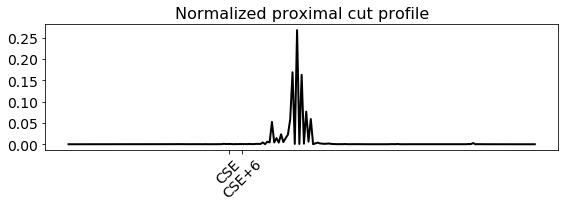

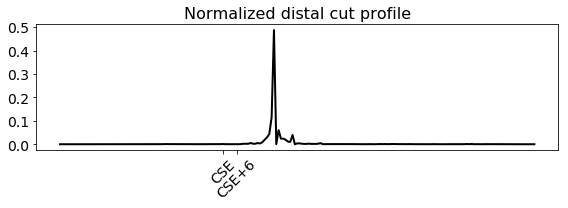

In [3]:
#Example APA sites from APADB (gene = PSMC6)

#Proximal and Distal PAS Sequences
seq_prox = 'AGATAGTGGTATAAGAAAGCATTTCTTATGACTTATTTTGTATCATTTGTTTTCCTCATCTAAAAAGTTGAATAAAATCTGTTTGATTCAGTTCTCCTACATATATATTCTTGTCTTTTCTGAGTATATTTACTGTGGTCCTTTAGGTTCTTTAGCAAGTAAACTATTTGATAACCCAGATGGATTGTGGATTTTTGAATATTAT'
seq_dist = 'TGGATTGTGGATTTTTGAATATTATTTTAAAATAGTACACATACTTAATGTTCATAAGATCATCTTCTTAAATAAAACATGGATGTGTGGGTATGTCTGTACTCCTCCTTTCAGAAAGTGTTTACATATTCTTCATCTACTGTGATTAAGCTCATTGTTGGTTAATTGAAAATATACATGCACATCCATAACTTTTTAAAGAGTA'

#Site Distance
site_distance = 180

#Proximal and Distal cut intervals within each sequence defining the isoforms
prox_cut_start, prox_cut_end = 80, 105
dist_cut_start, dist_cut_end = 80, 105

#One-hot encode the sequences
onehot_encoder = iso.OneHotEncoder(len(seq_prox))
onehot_prox, onehot_dist = onehot_encoder(seq_prox), onehot_encoder(seq_dist)

#Predict with base APARENT model
_, cut_pred_prox = aparent_model.predict(x=aparent_single_example_batch(onehot_prox))
_, cut_pred_dist = aparent_model.predict(x=aparent_single_example_batch(onehot_dist))

print("Non-normalized proximal sum-cut logit = " + str(logit(np.sum(cut_pred_prox[0, prox_cut_start:prox_cut_end]))))
print("Non-normalized distal sum-cut logit = " + str(logit(np.sum(cut_pred_dist[0, dist_cut_start:dist_cut_end]))))
print("")

#Predict with APADB-tuned APARENT model
iso_pred, cut_prox, cut_dist = apadb_model.predict(x=apadb_single_example_batch(onehot_prox, onehot_dist, prox_cut_start, prox_cut_end, dist_cut_start, dist_cut_end, site_distance))

print("Predicted proximal vs. distal isoform % (APADB) = " + str(iso_pred[0, 0]))

f = plt.figure(figsize=(8, 3))
plt.plot(np.arange(205), np.ravel(cut_prox), linewidth=2, color='black')
plt.title("Normalized proximal cut profile", fontsize=16)
plt.xticks([70, 76], ['CSE', 'CSE+6'], fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

f = plt.figure(figsize=(8, 3))
plt.plot(np.arange(205), np.ravel(cut_dist), linewidth=2, color='black')
plt.title("Normalized distal cut profile", fontsize=16)
plt.xticks([70, 76], ['CSE', 'CSE+6'], fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

<h2>Example 2: KTN1 Gene APA prediction</h2>
<br/>
-- First predict the non-normalized isoform score of each PAS sequence (score is relative to the average random MPRA distal bias).<br/>
-- Then predict the relative APA isoform abundance using the APADB-fitted model.<br/>
<br/>

Non-normalized proximal sum-cut logit = 0.7869834910584526
Non-normalized distal sum-cut logit = 3.4516517812954786

Predicted proximal vs. distal isoform % (APADB) = 0.084409095


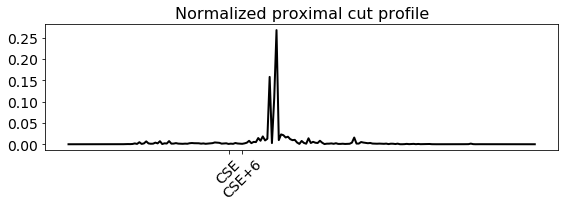

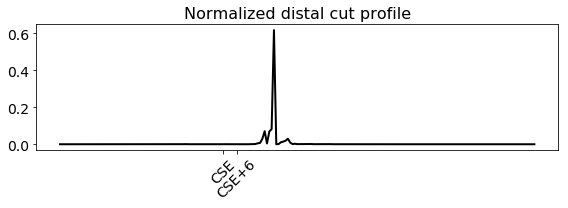

In [4]:
#Example APA sites from APADB (gene = KTN1)

seq_prox = 'AAAACTGTTTGAATAATTAGACCTTTACATTCCTGAAGATAAACATGTAATCTTTTATCTTATTTTGCTCAATAAAATTGTTCAGAAGATCAAAGTGGTAAAGACAATGTAAAATTTAACATTTTAATACTGATGTTGTACACTGTTTTACTTAACATTTTGGGAAGTAACTGCCTCTGACTTCAACTCAAGAAAACACTTTTTT'
seq_dist = 'GCCTCTGACTTCAACTCAAGAAAACACTTTTTTGTTGCTAATGTAATCGGTTTTTGTAATGGCGTCAGCAAATAAAAGGATGCTTATTATTCAAACTTGACTTGTTCTAATTTTTATTGAGCTTTAACAGATTTCATTAGTAGTACAGATCATTGTAATTTAGAATACAGCTATTAATTGGCAACCATTCAACAAGATAGGTTTA'

#Site Distance
site_distance = 171

#Proximal and Distal cut intervals within each sequence defining the isoforms
prox_cut_start, prox_cut_end = 70, 105
dist_cut_start, dist_cut_end = 70, 105

#One-hot encode the sequences
onehot_encoder = iso.OneHotEncoder(len(seq_prox))
onehot_prox, onehot_dist = onehot_encoder(seq_prox), onehot_encoder(seq_dist)

#Predict with base APARENT model
_, cut_pred_prox = aparent_model.predict(x=aparent_single_example_batch(onehot_prox))
_, cut_pred_dist = aparent_model.predict(x=aparent_single_example_batch(onehot_dist))

print("Non-normalized proximal sum-cut logit = " + str(logit(np.sum(cut_pred_prox[0, prox_cut_start:prox_cut_end]))))
print("Non-normalized distal sum-cut logit = " + str(logit(np.sum(cut_pred_dist[0, dist_cut_start:dist_cut_end]))))
print("")

#Predict with APADB-tuned APARENT model
iso_pred, cut_prox, cut_dist = apadb_model.predict(x=apadb_single_example_batch(onehot_prox, onehot_dist, prox_cut_start, prox_cut_end, dist_cut_start, dist_cut_end, site_distance))

print("Predicted proximal vs. distal isoform % (APADB) = " + str(iso_pred[0, 0]))

f = plt.figure(figsize=(8, 3))
plt.plot(np.arange(205), np.ravel(cut_prox), linewidth=2, color='black')
plt.title("Normalized proximal cut profile", fontsize=16)
plt.xticks([70, 76], ['CSE', 'CSE+6'], fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

f = plt.figure(figsize=(8, 3))
plt.plot(np.arange(205), np.ravel(cut_dist), linewidth=2, color='black')
plt.title("Normalized distal cut profile", fontsize=16)
plt.xticks([70, 76], ['CSE', 'CSE+6'], fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()
